In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as ss
import common_func as cf
import math

In [2]:
def find_trend(y, years):
    X_sm = sm.add_constant(years)
    lr = sm.OLS(y, X_sm).fit()
    return lr


def add_trend(y, years, add):
    if add:
        y_new = y + 0.0002 * years
        return y_new
    else:
        return y

In [3]:
def fit_exp(maxP, years, return_period):
    lnmaxP = np.log(maxP)
    y = add_trend(lnmaxP, years, False)
    lr = find_trend(y, years)
    CI = lr.conf_int(alpha=0.05)
    alpha, beta = lr.params
#     print(lr.summary())
    ybar,std, skew = cf.findmoments(y)
    n = len(years)
#     print(beta)
    tbar = np.mean(years)
    zp = ss.norm.ppf(1 - 1/return_period)

    # Vogel 2011 EQ 7
    xp = np.exp(ybar + beta*(years - tbar) + zp * std)
    return xp,beta, CI

In [4]:
def vogel_results(beta,del_t, rp,std):
    # EQ 9
    mag_f = np.exp(beta * del_t)
    cdf = 1-1/rp
    z_po = ss.norm.ppf(cdf)

    # EQ 12
    T_f = 1 /(1 - ss.norm.cdf(z_po -  (beta * del_t/ std)))
    return mag_f, T_f

100-year return period:16918.28 inch


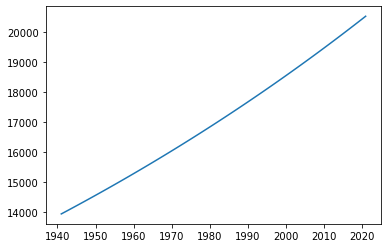

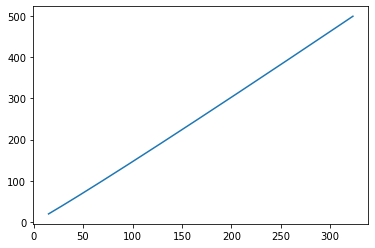

In [5]:
# Stations = ['station_04208000.csv','station_04196800.csv','station_04195500.csv','station_03117000.csv']
data = pd.read_csv('station_04208000.csv')

maxP, years = cf.annual_max(data)
lnmaxP = np.log(maxP)
ybar,std, skew = cf.findmoments(lnmaxP)
zp = ss.norm.ppf(0.99)
xp = np.exp(ybar + zp * std)
print('100-year return period:%5.2f' %xp,'inch')

# Plotting 100-year return period precipitation for different years
m, beta, CI = fit_exp(maxP, years, 100)
plt.plot(years,m)
plt.show()
return_periods = np.arange(20,500)

mag_f, T_f = vogel_results(beta,10, return_periods,std)


# Plotting 100-year return period precipitation for different years
plt.plot(T_f, return_periods)
plt.show()

In [8]:
#Recurrence Reduction and Confidence Interval
# delta_t = np.arange(0,40,10) #For Table
delta_t = np.arange(0,31,1) #For Graph
return_periods = [100, 200, 500, 1000]

results = pd.DataFrame()
for rp in return_periods: 
    results.loc[:, f"{rp}-year flood"] = vogel_results(beta, delta_t, rp,std)[1]
results.columns
# results['delta_t']=delta_t
# results.set_index('delta_t', inplace=True)
print(results)

#Call Beta CI
beta_H = CI[1][1]
beta_L = CI[1][0]
results_L = pd.DataFrame()
for rp in return_periods: 
    results_L.loc[:, f"{rp}-year flood"] = vogel_results(beta_L, delta_t, rp,std)[1]

results_H = pd.DataFrame()
for rp in return_periods: 
    results_H.loc[:, f"{rp}-year flood"] = vogel_results(beta_H, delta_t, rp,std)[1]

    100-year flood  200-year flood  500-year flood  1000-year flood
0       100.000000      200.000000      500.000000      1000.000000
1        96.340196      192.068963      478.303737       953.969254
2        92.830805      184.485573      457.632159       910.224095
3        89.465115      177.233412      437.933579       868.643978
4        86.236730      170.296886      419.159068       829.115049
5        83.139561      163.661184      401.262295       791.529754
6        80.167808      157.312231      384.199383       755.786478
7        77.315944      151.236653      367.928777       721.789197
8        74.578704      145.421742      352.411108       689.447162
9        71.951069      139.855418      337.609078       658.674592
10       69.428256      134.526194      323.487345       629.390391
11       67.005705      129.423153      310.012413       601.517878
12       64.679072      124.535911      297.152532       574.984540
13       62.444209      119.854592      284.8776

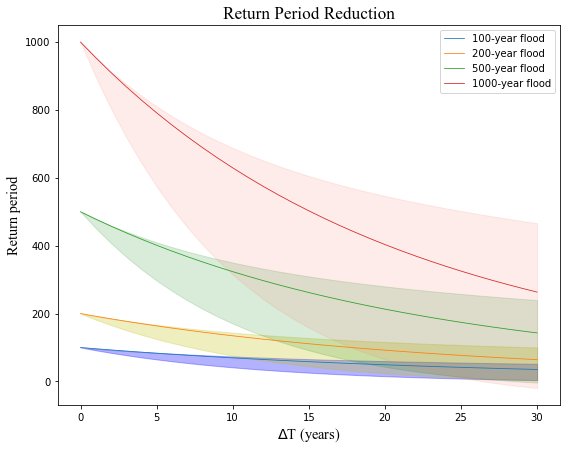

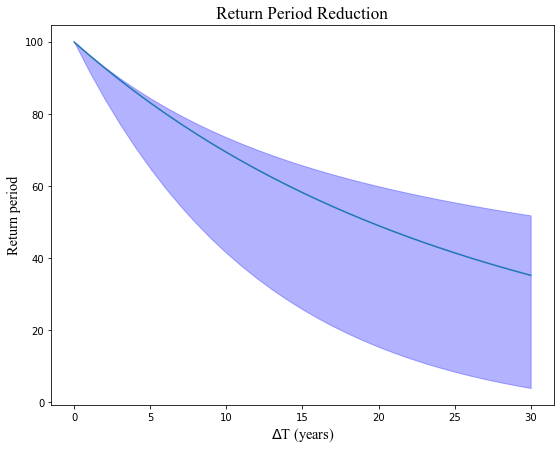

In [19]:
#Plot Tf vs To with Confidence Interval
plt.figure(figsize= [9, 7])
plt.plot(delta_t,results.iloc[:,:], label = results.columns, linewidth = 0.8)
hfont = {'fontname':'Times New Roman'}
plt.title('Return Period Reduction',fontsize='xx-large',**hfont)
plt.xlabel(r'$\Delta$'+'T (years)', fontsize='x-large',**hfont)
plt.ylabel("Return period", fontsize='x-large',**hfont)
plt.legend()


#confidence interval
ci_H = results_H-results
ci_L = results-results_L

plt.fill_between(delta_t, (results_H.loc[:,"100-year flood"]+ci_H.loc[:,"100-year flood"]), (results_H.loc[:,"100-year flood"]-ci_L.loc[:,"100-year flood"]), color='b', alpha=.3)
plt.fill_between(delta_t, (results_H.loc[:,"200-year flood"]+ci_H.loc[:,"200-year flood"]), (results_H.loc[:,"200-year flood"]-ci_L.loc[:,"200-year flood"]), color='y', alpha=.25)
plt.fill_between(delta_t, (results_H.loc[:,"500-year flood"]+ci_H.loc[:,"500-year flood"]), (results_H.loc[:,"500-year flood"]-ci_L.loc[:,"500-year flood"]), color='g', alpha=.15)
plt.fill_between(delta_t, (results_H.loc[:,"1000-year flood"]+ci_H.loc[:,"1000-year flood"]), (results_H.loc[:,"1000-year flood"]-ci_L.loc[:,"1000-year flood"]), color='salmon', alpha=.15)
plt.savefig('RecurrenceRed_CI.png')



#Plot 100-Year flood only with Confidence Interval
plt.figure(figsize= [9, 7])
plt.plot(delta_t,results.iloc[:,0:1])
hfont = {'fontname':'Times New Roman'}
plt.title('Return Period Reduction',fontsize='xx-large',**hfont)
plt.xlabel(r'$\Delta$'+'T (years)', fontsize='x-large',**hfont)
plt.ylabel("Return period", fontsize='x-large',**hfont)

#confidence interval
ci_H = results_H-results
ci_L = results-results_L
plt.fill_between(delta_t, (results_H.loc[:,"100-year flood"]+ci_H.loc[:,"100-year flood"]), (results_H.loc[:,"100-year flood"]-ci_L.loc[:,"100-year flood"]), color='b', alpha=.3)
# plt.fill_between(delta_t, (results_H.loc[:,"200-year flood"]+ci_H.loc[:,"200-year flood"]), (results_H.loc[:,"200-year flood"]-ci_L.loc[:,"200-year flood"]), color='y', alpha=.25)
plt.savefig('RecurrenceRed_CI_100yr.png')

In [ ]:
plt.plot(delta_t,results.iloc[:,:], label = results.columns)
plt.xlabel("Delta T")
plt.ylabel("Return period")
plt.legend()

In [ ]:
###Subplots
Stations = ['station_04208000.csv','station_04196800.csv','station_04195500.csv','station_03117000.csv']


fig, axs = plt.subplots(2,2, figsize=(14,8))#, sharex=True, sharey=True)
hfont = {'fontname':'Times New Roman'}
fig.suptitle('Return Period Reduction', fontsize='xx-large',**hfont)


for s in range(len(Stations)):
    data = pd.read_csv(Stations[s])
    maxP, years = cf.annual_max(data)
    lnmaxP = np.log(maxP)
    ybar,std, skew = cf.findmoments(lnmaxP)
    m, beta, CI = fit_exp(maxP, years, 100)
    delta_t = np.arange(0,21,1)
    return_periods = [100, 200, 500, 1000]
    results = pd.DataFrame()
    for rp in return_periods: 
        results.loc[:, f"{rp}-Year Flood"] = vogel_results(beta, delta_t, rp,std)[1]
    results.columns
  
    ax = axs[math.floor(s/2),s%2]
    ax.plot(delta_t,results.iloc[:,:])
    hfont = {'fontname':'Times New Roman'}
    ax.set_title('Station '+ str(s+1),fontsize='x-large',**hfont)
    
fig.legend(results.columns, loc = 'center right')
fig.text(0.5, 0.04, r'$\Delta$'+'T', ha='center',fontsize='x-large',**hfont)
fig.text(0.06, 0.5, 'Return Period', va='center', rotation='vertical',fontsize='x-large',**hfont)
    
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.85, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.2)
plt.savefig('Tf_delT_subplots.png')

In [ ]:
###Plot 100 and 200-year flood with all 5 stations
plt.figure(figsize= [7, 7])
hfont = {'fontname':'Times New Roman'}
plt.title('Return Period Reduction', fontsize='xx-large',**hfont)
plt.xlabel(r'$\Delta$'+'T (years)', fontsize='x-large',**hfont)
plt.ylabel("Return period", fontsize='x-large',**hfont)
st_color = ['blue','red','green','magenta']

for s in range(len(Stations)):
    data = pd.read_csv(Stations[s])
    maxP, years = cf.annual_max(data)
    lnmaxP = np.log(maxP)
    ybar,std, skew = cf.findmoments(lnmaxP)
    delta_t = np.arange(0,31,1)
    return_periods = [100, 200]
    results = pd.DataFrame()
    for rp in return_periods: 
        results.loc[:, f"{rp}-Year Flood"] = vogel_results(beta, delta_t, rp,std)[1]
    results.columns

    i = 0
    for i in range(1):
        if s==4:
            i = i+1
    plt.plot(delta_t,results.iloc[:,:], color = st_color[s], linewidth=0.75)
    plt.plot([],[], color = st_color[s], label='Station '+ str(s+1))

plt.legend()
plt.savefig('Tf_delT_100200.png')

In [ ]:
###Subplots
delta_T=20
plt.figure(figsize= [6, 4])
for s in range(len(Stations)):
    data = pd.read_csv(Stations[s])
    maxP, years = cf.annual_max(data)
    lnmaxP = np.log(maxP)
    ybar,std, skew = cf.findmoments(lnmaxP)
    m, beta, CI = fit_exp(maxP, years, 100)
    return_periods = np.arange(20,500)
    mag_f, T_f = vogel_results(beta,delta_T, return_periods,std) #
    plt.plot(T_f,return_periods,color = st_color[s])
    
plt.title('Recurrence Reduction after '+ r'$\Delta$T = '+str(delta_T)+' Years')
plt.xlabel('Future Return Period (Years)')
plt.ylabel('Current Return Period (Years)')
plt.savefig('Tf_To_delT10years.png')

In [ ]:
## Recurrence Reduction for 100-year flood

plt.figure(figsize= [6, 4])
rp = 1000
for s in range(len(Stations)):
    data = pd.read_csv(Stations[s])
    maxP, years = cf.annual_max(data)
    lnmaxP = np.log(maxP)
    ybar,std, skew = cf.findmoments(lnmaxP)
    m, beta, CI = fit_exp(maxP, years, rp)
    delta_t = np.arange(0,31,1)
    return_periods = [rp]
    results = pd.DataFrame()
    for rp in return_periods: 
        results.loc[:, f"{rp}-Year Flood"] = vogel_results(beta, delta_t, rp,std)[1]
    results.columns
    
    plt.plot(delta_t,results.iloc[:,:], label='Station '+str(s+1),color = st_color[s])

plt.legend()
plt.title('Recurrence Reduction for '+str(rp)+'-Year Flood', fontsize='xx-large',**hfont)
plt.xlabel(r'$\Delta$'+'T (years)', fontsize='x-large',**hfont)
plt.ylabel('Return Period',fontsize='x-large',**hfont)
plt.xlim(0,30)
plt.ylim(0,rp)
plt.savefig('Tf_delT_'+str(rp)+'yr.png')

In [ ]:
#Magnification Factor for all Stations

delta_t = np.arange(0,40,10)
rp = 100
results = pd.DataFrame()
 
for s in Stations:
    data = pd.read_csv(s)
    maxP, years = cf.annual_max(data)
    lnmaxP = np.log(maxP)
    ybar,std, skew = cf.findmoments(lnmaxP)
    m, beta, CI = fit_exp(maxP, years, 100)
    mag_f = vogel_results(beta, delta_t, rp,std)[0]

    results.loc[:,s] = mag_f
results['delta_t'] = delta_t
results.set_index('delta_t', inplace=True)
print(results)